In [ ]:
pip install numpy==1.26.4 torch transformers==4.48.2 scikit-learn accelerate==0.26.0 matplotlib tqdm pandas seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 92.9 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 96.3 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.7/270.7 kB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 94.4 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 110.9 MB/s eta 0:00:00a 0:00:01
  

In [4]:
import os
from collections import Counter

DATA_DIR = "/workspace/SEMUA_DATA_FILTERED"  # Ganti jika lokasimu berbeda
LABEL_MAP = {'AFIB': 0, 'N': 1, 'VFL': 2, 'VT': 3}

def get_class_distribution(data_dir):
    class_counts = {}
    total = 0
    for class_name in LABEL_MAP:
        class_path = os.path.join(data_dir, class_name)
        if os.path.exists(class_path):
            num_files = len([f for f in os.listdir(class_path) if f.endswith(".npy")])
            class_counts[class_name] = num_files
            total += num_files
        else:
            class_counts[class_name] = 0
    return class_counts, total

class_dist, total_files = get_class_distribution(DATA_DIR)

print("📊 Distribusi Kelas (TRAIN SET):")
print("========================================")
for cls, count in class_dist.items():
    print(f"  - {cls:<6} | Jumlah file: {count:4}")
print("========================================")
print(f"🔢 Jumlah Total Semua File: {total_files} file")


📊 Distribusi Kelas (TRAIN SET):
  - AFIB   | Jumlah file:  366
  - N      | Jumlah file:  390
  - VFL    | Jumlah file:   53
  - VT     | Jumlah file:   56
🔢 Jumlah Total Semua File: 865 file


In [3]:
import os
import numpy as np
from pathlib import Path
import shutil

# === KONFIGURASI ===
SOURCE_DIR = "/workspace/SEMUA_DATA"             # Folder data asli
TARGET_DIR = "/workspace/SEMUA_DATA_FILTERED"    # Folder output hasil filter
MIN_LEN = 3600  # 8 detik @360Hz

# === BUAT FOLDER BARU UNTUK SIMPAN HASIL FILTER ===
os.makedirs(TARGET_DIR, exist_ok=True)

total_kept = 0
total_skipped = 0

# === ITERASI SETIAP KELAS ===
for class_name in os.listdir(SOURCE_DIR):
    class_path = os.path.join(SOURCE_DIR, class_name)
    if not os.path.isdir(class_path):
        continue

    out_class_path = os.path.join(TARGET_DIR, class_name)
    os.makedirs(out_class_path, exist_ok=True)

    for file in os.listdir(class_path):
        if not file.endswith(".npy"):
            continue

        file_path = os.path.join(class_path, file)
        try:
            signal = np.load(file_path)

            if signal.ndim != 1 or len(signal) < MIN_LEN:
                total_skipped += 1
                continue

            # Simpan ke folder baru
            shutil.copy(file_path, os.path.join(out_class_path, file))
            total_kept += 1
        except Exception as e:
            print(f"[ERROR] Gagal memuat {file}: {e}")
            total_skipped += 1

print(f"[INFO] Total disimpan: {total_kept}")
print(f"[INFO] Total dilewati (pendek): {total_skipped}")


[INFO] Total disimpan: 865
[INFO] Total dilewati (pendek): 321


In [3]:
# =================== IMPORT ===================
import os, numpy as np, pandas as pd, random, shutil
import torch
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import (
    BertTokenizer, BertConfig, BertForSequenceClassification,
    Trainer, TrainingArguments, set_seed, TrainerCallback
)

# =================== CALLBACK LOG ===================
class LossLoggerCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None and "loss" in logs:
            print(f"[Training Loss] Epoch {state.epoch:.2f} | Step {state.global_step} | Loss: {logs['loss']:.4f}")

# =================== SPESIFISITAS PER KELAS ===================
def specificity_per_class(true, pred, label, num_classes):
    cm = confusion_matrix(true, pred, labels=list(range(num_classes)))
    TN = cm.sum() - (cm[label, :].sum() + cm[:, label].sum() - cm[label, label])
    FP = cm[:, label].sum() - cm[label, label]
    return TN / (TN + FP + 1e-8)

# =================== KONFIGURASI ===================
DATA_DIR   = "/workspace/SPLIT_SLIDING_FINAL/train"
OUTPUT_DIR = "/workspace/HASIL_BERT_KFOLD/HASIL_13"
LABEL_MAP  = {'AFIB': 0, 'VFL': 1, 'VT': 2}
N_SPLITS   = 5
SEED       = 42
EPOCHS     = 20
BATCH_SIZE = 16
LR         = 2e-5

set_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =================== LOAD DATA ===================
def load_data(data_dir):
    data, labels = [], []
    for label_name in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label_name)
        if label_name not in LABEL_MAP:
            continue
        for file in os.listdir(label_path):
            if file.endswith(".npy"):
                path = os.path.join(label_path, file)
                try:
                    signal = np.load(path)
                    if signal.ndim != 1:
                        continue
                    data.append(signal)
                    labels.append(LABEL_MAP[label_name])
                except:
                    continue
    return np.array(data, dtype=object), np.array(labels)

X, y = load_data(DATA_DIR)

# =================== SIGNAL TO TEXT ===================
def signal_to_text(sig, target_len=512):
    if len(sig) < target_len:
        pad = np.full(target_len - len(sig), sig[-1])
        sig = np.concatenate([sig, pad])
    else:
        idx = np.linspace(0, len(sig)-1, target_len).astype(int)
        sig = sig[idx]
    norm = ((sig - sig.min()) / (sig.ptp() + 1e-8) * 255).astype(int)
    return " ".join(map(str, norm))

texts = [signal_to_text(sig) for sig in X]

# =================== TOKENIZER ===================
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
def tokenize_batch(texts):
    return tokenizer(texts, padding='max_length', truncation=True, max_length=512, return_tensors="pt")

# =================== DATASET ===================
class ECGDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

# =================== METRIK GLOBAL ===================
def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    labels = pred.label_ids
    acc = accuracy_score(labels, preds)
    recall = recall_score(labels, preds, average='macro', zero_division=0)
    f1 = f1_score(labels, preds, average='macro', zero_division=0)

    cm = confusion_matrix(labels, preds)
    specs = []
    for class_idx in range(len(LABEL_MAP)):
        spec = specificity_per_class(labels, preds, class_idx, num_classes=len(LABEL_MAP))
        specs.append(spec)
    specificity = np.mean(specs)

    print(f"[Metrics] Accuracy: {acc:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | Specificity: {specificity:.4f}")
    return { "accuracy": acc, "recall": recall, "f1": f1, "specificity": specificity }

# =================== TRAINING LOOP ===================
results_all = []
best_f1 = 0
best_fold = None
best_model_path = ""

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
for fold, (train_idx, val_idx) in enumerate(skf.split(texts, y), 1):
    print(f"\n[INFO] Fold {fold}")
    X_train, X_val = [texts[i] for i in train_idx], [texts[i] for i in val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    train_enc = tokenize_batch(X_train)
    val_enc = tokenize_batch(X_val)
    train_dataset = ECGDataset(train_enc, y_train)
    val_dataset = ECGDataset(val_enc, y_val)

    config = BertConfig.from_pretrained("bert-base-uncased",
        num_labels=len(LABEL_MAP),
        hidden_dropout_prob=0.2,
        attention_probs_dropout_prob=0.2)

    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", config=config).to(device)

    fold_dir = os.path.join(OUTPUT_DIR, f"fold{fold}")
    os.makedirs(fold_dir, exist_ok=True)

    training_args = TrainingArguments(
        output_dir=os.path.join(fold_dir, "model"),
        evaluation_strategy="epoch",
        logging_strategy="epoch",
        save_strategy="no",
        learning_rate=LR,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=EPOCHS,
        weight_decay=0.01,
        report_to="none",
        logging_dir=os.path.join(fold_dir, "logs"),
        logging_steps=100,
        save_total_limit=1
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[LossLoggerCallback()]
    )

    trainer.train()

    trainer.save_model(os.path.join(fold_dir, "model"))
    tokenizer.save_pretrained(os.path.join(fold_dir, "model"))

    pred_output = trainer.predict(val_dataset)
    eval_result = compute_metrics(pred_output)
    preds = np.argmax(pred_output.predictions, axis=1)
    labels = y_val

    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=True,
                xticklabels=LABEL_MAP.keys(), yticklabels=LABEL_MAP.keys())
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix Fold {fold}")
    plt.tight_layout()
    plt.savefig(os.path.join(fold_dir, f"confmat_fold{fold}.png"))
    plt.close()

    df_class = []
    for class_idx, class_name in enumerate(LABEL_MAP.keys()):
        true_binary = (labels == class_idx).astype(int)
        pred_binary = (preds == class_idx).astype(int)
        acc = accuracy_score(true_binary, pred_binary)
        rec = recall_score(true_binary, pred_binary, zero_division=0)
        f1s = f1_score(true_binary, pred_binary, zero_division=0)
        spec = specificity_per_class(labels, preds, class_idx, num_classes=len(LABEL_MAP))
        df_class.append([fold, class_name, acc, rec, f1s, spec])

    df_fold = pd.DataFrame(df_class, columns=["fold", "kelas", "akurasi", "recall", "f1 score", "spesifisitas"])
    df_fold.to_csv(os.path.join(fold_dir, f"hasil_fold{fold}.csv"), index=False)

    results_all.append(eval_result)

    if eval_result["f1"] > best_f1:
        best_f1 = eval_result["f1"]
        best_fold = fold
        best_model_path = os.path.join(fold_dir, "model")
        shutil.copyfile(os.path.join(fold_dir, f"confmat_fold{fold}.png"), os.path.join(OUTPUT_DIR, "confmat_final.png"))

# Copy best model ke OUTPUT_DIR
if best_model_path:
    shutil.copytree(best_model_path, os.path.join(OUTPUT_DIR, "bert_best"), dirs_exist_ok=True)

# Gabungkan semua hasil CSV per fold
all_df = []
for fold in range(1, N_SPLITS+1):
    csv_path = os.path.join(OUTPUT_DIR, f"fold{fold}", f"hasil_fold{fold}.csv")
    if os.path.exists(csv_path):
        all_df.append(pd.read_csv(csv_path))

final_df = pd.concat(all_df, ignore_index=True)
final_df.to_csv(os.path.join(OUTPUT_DIR, "hasil_kfold_bert.csv"), index=False)
print(f"[INFO] Fold terbaik berdasarkan F1-score: Fold {best_fold}")


[INFO] Fold 1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Recall,F1,Specificity
1,0.728600,0.470535,0.847917,0.847917,0.847526,0.923958
2,0.399200,0.375539,0.890625,0.890625,0.890741,0.945312
3,0.285900,0.362528,0.870833,0.870833,0.871571,0.935417
4,0.213400,0.380744,0.903125,0.903125,0.903381,0.951562
5,0.162900,0.383562,0.912500,0.912500,0.912029,0.956250
6,0.137100,0.304787,0.933333,0.933333,0.933324,0.966667
7,0.105100,0.341182,0.938542,0.938542,0.938537,0.969271
8,0.088400,0.295640,0.945833,0.945833,0.945774,0.972917
9,0.069700,0.349119,0.943750,0.943750,0.943773,0.971875
10,0.059600,0.330765,0.944792,0.944792,0.944789,0.972396


[Training Loss] Epoch 1.00 | Step 240 | Loss: 0.7286
[Metrics] Accuracy: 0.8479 | Recall: 0.8479 | F1: 0.8475 | Specificity: 0.9240
[Training Loss] Epoch 2.00 | Step 480 | Loss: 0.3992
[Metrics] Accuracy: 0.8906 | Recall: 0.8906 | F1: 0.8907 | Specificity: 0.9453
[Training Loss] Epoch 3.00 | Step 720 | Loss: 0.2859
[Metrics] Accuracy: 0.8708 | Recall: 0.8708 | F1: 0.8716 | Specificity: 0.9354
[Training Loss] Epoch 4.00 | Step 960 | Loss: 0.2134
[Metrics] Accuracy: 0.9031 | Recall: 0.9031 | F1: 0.9034 | Specificity: 0.9516
[Training Loss] Epoch 5.00 | Step 1200 | Loss: 0.1629
[Metrics] Accuracy: 0.9125 | Recall: 0.9125 | F1: 0.9120 | Specificity: 0.9562
[Training Loss] Epoch 6.00 | Step 1440 | Loss: 0.1371
[Metrics] Accuracy: 0.9333 | Recall: 0.9333 | F1: 0.9333 | Specificity: 0.9667
[Training Loss] Epoch 7.00 | Step 1680 | Loss: 0.1051
[Metrics] Accuracy: 0.9385 | Recall: 0.9385 | F1: 0.9385 | Specificity: 0.9693
[Training Loss] Epoch 8.00 | Step 1920 | Loss: 0.0884
[Metrics] Accuracy:

[Metrics] Accuracy: 0.9521 | Recall: 0.9521 | F1: 0.9521 | Specificity: 0.9760
[Metrics] Accuracy: 0.9521 | Recall: 0.9521 | F1: 0.9521 | Specificity: 0.9760

[INFO] Fold 2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Recall,F1,Specificity
1,0.790600,0.489757,0.832292,0.832292,0.832999,0.916146
2,0.394800,0.352817,0.902083,0.902083,0.901766,0.951042
3,0.285900,0.299756,0.932292,0.932292,0.932167,0.966146
4,0.229200,0.263116,0.933333,0.933333,0.933103,0.966667
5,0.161000,0.250790,0.950000,0.950000,0.949858,0.975000
6,0.140400,0.262941,0.946875,0.946875,0.946779,0.973437
7,0.119400,0.236477,0.955208,0.955208,0.955053,0.977604
8,0.091800,0.206127,0.959375,0.959375,0.959349,0.979687
9,0.070000,0.267905,0.958333,0.958333,0.958316,0.979167
10,0.065900,0.251837,0.962500,0.962500,0.962444,0.981250


[Training Loss] Epoch 1.00 | Step 240 | Loss: 0.7906
[Metrics] Accuracy: 0.8323 | Recall: 0.8323 | F1: 0.8330 | Specificity: 0.9161
[Training Loss] Epoch 2.00 | Step 480 | Loss: 0.3948
[Metrics] Accuracy: 0.9021 | Recall: 0.9021 | F1: 0.9018 | Specificity: 0.9510
[Training Loss] Epoch 3.00 | Step 720 | Loss: 0.2859
[Metrics] Accuracy: 0.9323 | Recall: 0.9323 | F1: 0.9322 | Specificity: 0.9661
[Training Loss] Epoch 4.00 | Step 960 | Loss: 0.2292
[Metrics] Accuracy: 0.9333 | Recall: 0.9333 | F1: 0.9331 | Specificity: 0.9667
[Training Loss] Epoch 5.00 | Step 1200 | Loss: 0.1610
[Metrics] Accuracy: 0.9500 | Recall: 0.9500 | F1: 0.9499 | Specificity: 0.9750
[Training Loss] Epoch 6.00 | Step 1440 | Loss: 0.1404
[Metrics] Accuracy: 0.9469 | Recall: 0.9469 | F1: 0.9468 | Specificity: 0.9734
[Training Loss] Epoch 7.00 | Step 1680 | Loss: 0.1194
[Metrics] Accuracy: 0.9552 | Recall: 0.9552 | F1: 0.9551 | Specificity: 0.9776
[Training Loss] Epoch 8.00 | Step 1920 | Loss: 0.0918
[Metrics] Accuracy:

[Metrics] Accuracy: 0.9510 | Recall: 0.9510 | F1: 0.9507 | Specificity: 0.9755
[Metrics] Accuracy: 0.9510 | Recall: 0.9510 | F1: 0.9507 | Specificity: 0.9755

[INFO] Fold 3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Recall,F1,Specificity
1,0.764100,0.440321,0.856250,0.856250,0.856232,0.928125
2,0.399400,0.285757,0.909375,0.909375,0.909237,0.954687
3,0.286300,0.213656,0.933333,0.933333,0.933238,0.966667
4,0.198600,0.280823,0.930208,0.930208,0.929748,0.965104
5,0.166000,0.179165,0.955208,0.955208,0.955168,0.977604
6,0.150700,0.206749,0.948958,0.948958,0.948802,0.974479
7,0.105200,0.174714,0.960417,0.960417,0.960286,0.980208
8,0.090100,0.233611,0.959375,0.959375,0.959448,0.979687
9,0.078100,0.187267,0.965625,0.965625,0.965669,0.982812
10,0.060100,0.264710,0.956250,0.956250,0.956304,0.978125


[Training Loss] Epoch 1.00 | Step 240 | Loss: 0.7641
[Metrics] Accuracy: 0.8562 | Recall: 0.8562 | F1: 0.8562 | Specificity: 0.9281
[Training Loss] Epoch 2.00 | Step 480 | Loss: 0.3994
[Metrics] Accuracy: 0.9094 | Recall: 0.9094 | F1: 0.9092 | Specificity: 0.9547
[Training Loss] Epoch 3.00 | Step 720 | Loss: 0.2863
[Metrics] Accuracy: 0.9333 | Recall: 0.9333 | F1: 0.9332 | Specificity: 0.9667
[Training Loss] Epoch 4.00 | Step 960 | Loss: 0.1986
[Metrics] Accuracy: 0.9302 | Recall: 0.9302 | F1: 0.9297 | Specificity: 0.9651
[Training Loss] Epoch 5.00 | Step 1200 | Loss: 0.1660
[Metrics] Accuracy: 0.9552 | Recall: 0.9552 | F1: 0.9552 | Specificity: 0.9776
[Training Loss] Epoch 6.00 | Step 1440 | Loss: 0.1507
[Metrics] Accuracy: 0.9490 | Recall: 0.9490 | F1: 0.9488 | Specificity: 0.9745
[Training Loss] Epoch 7.00 | Step 1680 | Loss: 0.1052
[Metrics] Accuracy: 0.9604 | Recall: 0.9604 | F1: 0.9603 | Specificity: 0.9802
[Training Loss] Epoch 8.00 | Step 1920 | Loss: 0.0901
[Metrics] Accuracy:

[Metrics] Accuracy: 0.9573 | Recall: 0.9573 | F1: 0.9572 | Specificity: 0.9786
[Metrics] Accuracy: 0.9573 | Recall: 0.9573 | F1: 0.9572 | Specificity: 0.9786

[INFO] Fold 4


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Recall,F1,Specificity
1,0.823200,0.652255,0.758333,0.758333,0.756130,0.879167
2,0.451700,0.499129,0.855208,0.855208,0.854905,0.927604
3,0.345600,0.476069,0.878125,0.878125,0.878074,0.939062
4,0.258000,0.408530,0.900000,0.900000,0.899789,0.950000
5,0.193800,0.416576,0.905208,0.905208,0.905340,0.952604
6,0.171500,0.334724,0.926042,0.926042,0.925860,0.963021
7,0.143600,0.289842,0.938542,0.938542,0.938513,0.969271
8,0.116300,0.330981,0.939583,0.939583,0.939681,0.969792
9,0.093800,0.341865,0.941667,0.941667,0.941508,0.970833
10,0.079500,0.316260,0.944792,0.944792,0.944643,0.972396


[Training Loss] Epoch 1.00 | Step 240 | Loss: 0.8232
[Metrics] Accuracy: 0.7583 | Recall: 0.7583 | F1: 0.7561 | Specificity: 0.8792
[Training Loss] Epoch 2.00 | Step 480 | Loss: 0.4517
[Metrics] Accuracy: 0.8552 | Recall: 0.8552 | F1: 0.8549 | Specificity: 0.9276
[Training Loss] Epoch 3.00 | Step 720 | Loss: 0.3456
[Metrics] Accuracy: 0.8781 | Recall: 0.8781 | F1: 0.8781 | Specificity: 0.9391
[Training Loss] Epoch 4.00 | Step 960 | Loss: 0.2580
[Metrics] Accuracy: 0.9000 | Recall: 0.9000 | F1: 0.8998 | Specificity: 0.9500
[Training Loss] Epoch 5.00 | Step 1200 | Loss: 0.1938
[Metrics] Accuracy: 0.9052 | Recall: 0.9052 | F1: 0.9053 | Specificity: 0.9526
[Training Loss] Epoch 6.00 | Step 1440 | Loss: 0.1715
[Metrics] Accuracy: 0.9260 | Recall: 0.9260 | F1: 0.9259 | Specificity: 0.9630
[Training Loss] Epoch 7.00 | Step 1680 | Loss: 0.1436
[Metrics] Accuracy: 0.9385 | Recall: 0.9385 | F1: 0.9385 | Specificity: 0.9693
[Training Loss] Epoch 8.00 | Step 1920 | Loss: 0.1163
[Metrics] Accuracy:

[Metrics] Accuracy: 0.9375 | Recall: 0.9375 | F1: 0.9370 | Specificity: 0.9687
[Metrics] Accuracy: 0.9375 | Recall: 0.9375 | F1: 0.9370 | Specificity: 0.9687

[INFO] Fold 5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Recall,F1,Specificity
1,0.838100,0.514930,0.822917,0.822917,0.823037,0.911458
2,0.498900,0.296047,0.902083,0.902083,0.902137,0.951042
3,0.334700,0.183256,0.946875,0.946875,0.946851,0.973437
4,0.245700,0.269961,0.926042,0.926042,0.926302,0.963021
5,0.189800,0.209887,0.953125,0.953125,0.953138,0.976562
6,0.154800,0.239242,0.950000,0.950000,0.949968,0.975000
7,0.144400,0.129096,0.968750,0.968750,0.968752,0.984375
8,0.118000,0.155082,0.962500,0.962500,0.962603,0.981250
9,0.093700,0.171520,0.963542,0.963542,0.963533,0.981771
10,0.082200,0.175273,0.965625,0.965625,0.965598,0.982812


[Training Loss] Epoch 1.00 | Step 240 | Loss: 0.8381
[Metrics] Accuracy: 0.8229 | Recall: 0.8229 | F1: 0.8230 | Specificity: 0.9115
[Training Loss] Epoch 2.00 | Step 480 | Loss: 0.4989
[Metrics] Accuracy: 0.9021 | Recall: 0.9021 | F1: 0.9021 | Specificity: 0.9510
[Training Loss] Epoch 3.00 | Step 720 | Loss: 0.3347
[Metrics] Accuracy: 0.9469 | Recall: 0.9469 | F1: 0.9469 | Specificity: 0.9734
[Training Loss] Epoch 4.00 | Step 960 | Loss: 0.2457
[Metrics] Accuracy: 0.9260 | Recall: 0.9260 | F1: 0.9263 | Specificity: 0.9630
[Training Loss] Epoch 5.00 | Step 1200 | Loss: 0.1898
[Metrics] Accuracy: 0.9531 | Recall: 0.9531 | F1: 0.9531 | Specificity: 0.9766
[Training Loss] Epoch 6.00 | Step 1440 | Loss: 0.1548
[Metrics] Accuracy: 0.9500 | Recall: 0.9500 | F1: 0.9500 | Specificity: 0.9750
[Training Loss] Epoch 7.00 | Step 1680 | Loss: 0.1444
[Metrics] Accuracy: 0.9688 | Recall: 0.9688 | F1: 0.9688 | Specificity: 0.9844
[Training Loss] Epoch 8.00 | Step 1920 | Loss: 0.1180
[Metrics] Accuracy:

[Metrics] Accuracy: 0.9677 | Recall: 0.9677 | F1: 0.9677 | Specificity: 0.9839
[Metrics] Accuracy: 0.9677 | Recall: 0.9677 | F1: 0.9677 | Specificity: 0.9839
[INFO] Fold terbaik berdasarkan F1-score: Fold 5


[BERT TEST] Akurasi: 0.4800 | Recall: 0.4800 | F1-score: 0.4351


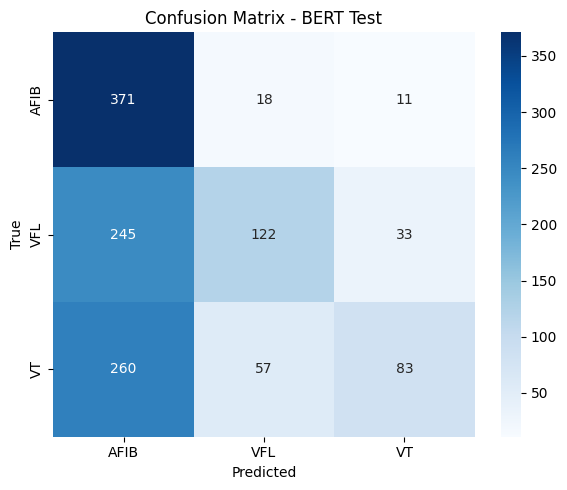

In [5]:
import os
import torch
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

# === KONFIGURASI ===
TEST_DIR = "/workspace/SPLIT_SLIDING_FINAL/test"
MODEL_DIR = "/workspace/HASIL_BERT_KFOLD/HASIL_11/fold4/model"
LABEL_MAP = {'AFIB': 0, 'VFL': 1, 'VT': 2}
IDX2LABEL = {v: k for k, v in LABEL_MAP.items()}
MAX_LEN = 512
BATCH_SIZE = 16
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === LOAD TOKENIZER & MODEL ===
tokenizer = BertTokenizer.from_pretrained(MODEL_DIR)
model = BertForSequenceClassification.from_pretrained(MODEL_DIR).to(DEVICE)
model.eval()

# === PREPROSES SINYAL KE TEKS ===
def signal_to_text(sig: np.ndarray) -> str:
    sig = (sig - sig.min()) / (sig.ptp() + 1e-8)
    sig = (sig * 255).astype(int)
    return " ".join(map(str, sig.tolist()))

# === LOAD DATA ===
texts, labels = [], []
for label in os.listdir(TEST_DIR):
    if label not in LABEL_MAP: continue
    folder = os.path.join(TEST_DIR, label)
    for file in os.listdir(folder):
        if file.endswith(".npy"):
            sig = np.load(os.path.join(folder, file), allow_pickle=True)
            if isinstance(sig, np.ndarray) and sig.ndim == 1:
                texts.append(signal_to_text(sig))
                labels.append(LABEL_MAP[label])
labels = np.array(labels)

# === TOKENISASI (tanpa tensors dulu)
encodings = tokenizer(texts, padding='max_length', truncation=True, max_length=MAX_LEN)

# === Dataset & DataLoader ===
class ECGDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

test_dataset = ECGDataset(encodings, labels)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# === INFERENSI ===
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels_batch = batch['labels'].to(DEVICE)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = outputs.logits.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

# === EVALUASI ===
acc = accuracy_score(all_labels, all_preds)
rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1s = f1_score(all_labels, all_preds, average='macro', zero_division=0)
cm = confusion_matrix(all_labels, all_preds)

print(f"[BERT TEST] Akurasi: {acc:.4f} | Recall: {rec:.4f} | F1-score: {f1s:.4f}")

# === VISUAL CONFUSION MATRIX ===
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=LABEL_MAP.keys(), yticklabels=LABEL_MAP.keys())
plt.title("Confusion Matrix - BERT Test")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


=== Evaluasi Model BERT Base (Best Model) ===
Akurasi     : 0.9650
Recall      : 0.9650
F1-score    : 0.9650
Spesifisitas: 0.9825


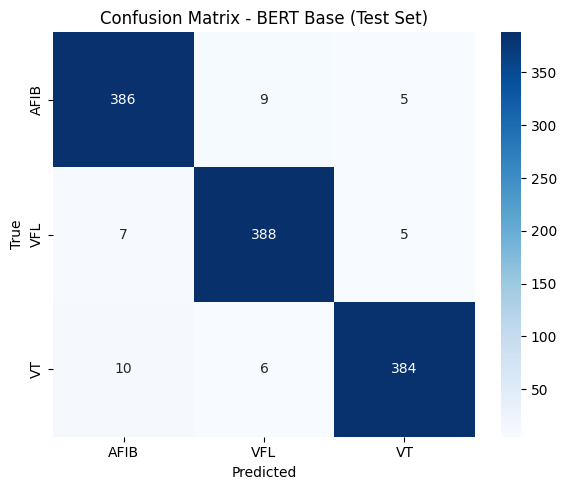

In [4]:
import os, numpy as np, pandas as pd
import torch
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification
import seaborn as sns
import matplotlib.pyplot as plt

# === KONFIGURASI ===
MODEL_PATH = "/workspace/HASIL_BERT_KFOLD/HASIL_13/bert_best"
TEST_DIR   = "/workspace/SPLIT_SLIDING_FINAL/test"
LABEL_MAP  = {'AFIB': 0, 'VFL': 1, 'VT': 2}
IDX2LABEL  = {v: k for k, v in LABEL_MAP.items()}
MAX_LEN    = 512
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === LOAD TOKENIZER DAN MODEL ===
tokenizer = BertTokenizer.from_pretrained(MODEL_PATH)
model = BertForSequenceClassification.from_pretrained(MODEL_PATH).to(DEVICE)
model.eval()

# === UTILS ===
def signal_to_text(sig, target_len=512):
    if len(sig) < target_len:
        pad = np.full(target_len - len(sig), sig[-1])
        sig = np.concatenate([sig, pad])
    else:
        idx = np.linspace(0, len(sig) - 1, target_len).astype(int)
        sig = sig[idx]
    norm = ((sig - sig.min()) / (sig.ptp() + 1e-8) * 255).astype(int)
    return " ".join(map(str, norm))

def load_test_data(test_dir):
    data, labels = [], []
    for label_name in os.listdir(test_dir):
        folder_path = os.path.join(test_dir, label_name)
        if label_name not in LABEL_MAP:
            continue
        for file in os.listdir(folder_path):
            if file.endswith(".npy"):
                sig = np.load(os.path.join(folder_path, file), allow_pickle=True)
                if isinstance(sig, np.ndarray) and sig.ndim == 1:
                    data.append(signal_to_text(sig))
                    labels.append(LABEL_MAP[label_name])
    return data, np.array(labels)

# === LOAD DATA TEST ===
texts, y_true = load_test_data(TEST_DIR)

# === INFERENSI ===
preds = []
batch_size = 32
for i in range(0, len(texts), batch_size):
    batch_texts = texts[i:i+batch_size]
    encodings = tokenizer(batch_texts, padding="max_length", truncation=True, max_length=MAX_LEN, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        outputs = model(**encodings)
        logits = outputs.logits
        preds.extend(torch.argmax(logits, dim=1).cpu().numpy())

# === EVALUASI ===
acc  = accuracy_score(y_true, preds)
rec  = recall_score(y_true, preds, average='macro', zero_division=0)
f1   = f1_score(y_true, preds, average='macro', zero_division=0)
cm   = confusion_matrix(y_true, preds)

def specificity_per_class(true, pred, label, num_classes):
    cm = confusion_matrix(true, pred, labels=list(range(num_classes)))
    TN = cm.sum() - (cm[label, :].sum() + cm[:, label].sum() - cm[label, label])
    FP = cm[:, label].sum() - cm[label, label]
    return TN / (TN + FP + 1e-8)

spec = np.mean([specificity_per_class(y_true, preds, i, len(LABEL_MAP)) for i in range(len(LABEL_MAP))])

# === CETAK HASIL ===
print(f"\n=== Evaluasi Model BERT Base (Best Model) ===")
print(f"Akurasi     : {acc:.4f}")
print(f"Recall      : {rec:.4f}")
print(f"F1-score    : {f1:.4f}")
print(f"Spesifisitas: {spec:.4f}")

# === CONFUSION MATRIX ===
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=LABEL_MAP.keys(),
            yticklabels=LABEL_MAP.keys())
plt.title("Confusion Matrix - BERT Base (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig(os.path.join(MODEL_PATH, "confmat_test.png"))
plt.show()


In [3]:
import os, numpy as np, pandas as pd
import torch
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification
import seaborn as sns
import matplotlib.pyplot as plt

# === KONFIGURASI ===
MODEL_PATH  = r"D:\KULIAH\TELKOM_UNIVERSITY\SEMESTER_8\TA\TA_SKRIPSI_GUE\HASIL_TRAIN\RYTHM\HASIL_Final_BERT_RYTHM\HASIL_Final_BERT_RYTHM\fold3\model"
TEST_DIR    = r"D:\KULIAH\TELKOM_UNIVERSITY\SEMESTER_8\TA\TA_SKRIPSI_GUE\SPLIT_SLIDING_FINAL\SPLIT_SLIDING_FINAL\test"
LABEL_MAP   = {'AFIB': 0, 'VFL': 1, 'VT': 2}
IDX2LABEL   = {v: k for k, v in LABEL_MAP.items()}
MAX_LEN     = 512
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === OUTPUT DIR ===
OUTPUT_DIR = r"D:\KULIAH\TELKOM_UNIVERSITY\SEMESTER_8\TA\TA_SKRIPSI_GUE\HASIL_AKHIR_RECORD\RYTHM\RHYTHM_EVALUASI_BERT"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# === LOAD TOKENIZER DAN MODEL ===
tokenizer = BertTokenizer.from_pretrained(MODEL_PATH)
model = BertForSequenceClassification.from_pretrained(MODEL_PATH).to(DEVICE)
model.eval()

# === UTILS ===
def signal_to_text(sig, target_len=512):
    if len(sig) < target_len:
        pad = np.full(target_len - len(sig), sig[-1])
        sig = np.concatenate([sig, pad])
    else:
        idx = np.linspace(0, len(sig) - 1, target_len).astype(int)
        sig = sig[idx]
    norm = ((sig - sig.min()) / (sig.ptp() + 1e-8) * 255).astype(int)
    return " ".join(map(str, norm))

def load_test_data(test_dir):
    data, labels = [], []
    for label_name in os.listdir(test_dir):
        folder_path = os.path.join(test_dir, label_name)
        if label_name not in LABEL_MAP:
            continue
        for file in os.listdir(folder_path):
            if file.endswith(".npy"):
                sig = np.load(os.path.join(folder_path, file), allow_pickle=True)
                if isinstance(sig, np.ndarray) and sig.ndim == 1:
                    data.append(signal_to_text(sig))
                    labels.append(LABEL_MAP[label_name])
    return data, np.array(labels)

# === LOAD DATA TEST ===
texts, y_true = load_test_data(TEST_DIR)

# === INFERENSI ===
preds = []
batch_size = 32
for i in range(0, len(texts), batch_size):
    batch_texts = texts[i:i+batch_size]
    encodings = tokenizer(batch_texts, padding="max_length", truncation=True, max_length=MAX_LEN, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        outputs = model(**encodings)
        logits = outputs.logits
        preds.extend(torch.argmax(logits, dim=1).cpu().numpy())

# === EVALUASI GLOBAL ===
acc  = accuracy_score(y_true, preds)
rec  = recall_score(y_true, preds, average='macro', zero_division=0)
f1   = f1_score(y_true, preds, average='macro', zero_division=0)
cm   = confusion_matrix(y_true, preds)

def specificity_per_class(true, pred, label, num_classes):
    cm = confusion_matrix(true, pred, labels=list(range(num_classes)))
    TN = cm.sum() - (cm[label, :].sum() + cm[:, label].sum() - cm[label, label])
    FP = cm[:, label].sum() - cm[label, label]
    return TN / (TN + FP + 1e-8)

spec = np.mean([specificity_per_class(y_true, preds, i, len(LABEL_MAP)) for i in range(len(LABEL_MAP))])

# === SIMPAN CONFUSION MATRIX PNG ===
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=LABEL_MAP.keys(),
            yticklabels=LABEL_MAP.keys())
plt.title("Confusion Matrix - BERT Base (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "confmat_test.png"))
plt.close()

# === SIMPAN METRIK PER KELAS CSV ===
rows = []
for i, label in IDX2LABEL.items():
    TP = cm[i,i]
    FN = cm[i].sum() - TP
    FP = cm[:,i].sum() - TP
    TN = cm.sum() - TP - FN - FP
    acc_cls  = (TP + TN) / cm.sum()
    rec_cls  = TP / (TP + FN + 1e-8)
    spec_cls = TN / (TN + FP + 1e-8)
    f1_cls   = 2 * TP / (2 * TP + FP + FN + 1e-8)
    rows.append({
        "kelas": label,
        "akurasi": round(acc_cls, 4),
        "recall": round(rec_cls, 4),
        "f1": round(f1_cls, 4),
        "spesifisitas": round(spec_cls, 4)
    })
df = pd.DataFrame(rows)
df.to_csv(os.path.join(OUTPUT_DIR, "summary_test_metrics.csv"), index=False)

# === CETAK HASIL RINGKAS DI TERMINAL ===
print(f"\n=== Evaluasi Model BERT Base (Best Model) ===")
print(f"Akurasi     : {acc:.4f}")
print(f"Recall      : {rec:.4f}")
print(f"F1-score    : {f1:.4f}")
print(f"Spesifisitas: {spec:.4f}")
print(f"📂 Semua hasil disimpan ke: {OUTPUT_DIR}")


=== Evaluasi Model BERT Base (Best Model) ===
Akurasi     : 0.9542
Recall      : 0.9542
F1-score    : 0.9541
Spesifisitas: 0.9771
📂 Semua hasil disimpan ke: D:\KULIAH\TELKOM_UNIVERSITY\SEMESTER_8\TA\TA_SKRIPSI_GUE\HASIL_AKHIR_RECORD\RYTHM\RHYTHM_EVALUASI_BERT
